In [1]:
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.result import QuasiDistribution
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

budget = 2000
risk_tolerance = 0.5 # q 
penalty = 40 #lambda 

tickers = ['AAPL', 'IBM', 'NFLX', 'TSLA']
data = yf.download(tickers, start="2023-01-01", end="2025-01-01")

close_prices = data['Close']

returns = close_prices.pct_change().dropna()
mean_returns = returns.mean()
for ticker in tickers:
    print(f"Average daily return for {ticker}: {mean_returns[ticker]:.4f}")
cov_matrix = returns.cov()
print("\nCovariance Matrix:")   
print(cov_matrix)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed

Average daily return for AAPL: 0.0015
Average daily return for IBM: 0.0011
Average daily return for NFLX: 0.0024
Average daily return for TSLA: 0.0033

Covariance Matrix:
Ticker      AAPL       IBM      NFLX      TSLA
Ticker                                        
AAPL    0.000181  0.000025  0.000103  0.000186
IBM     0.000025  0.000158  0.000040  0.000007
NFLX    0.000103  0.000040  0.000454  0.000191
TSLA    0.000186  0.000007  0.000191  0.001349


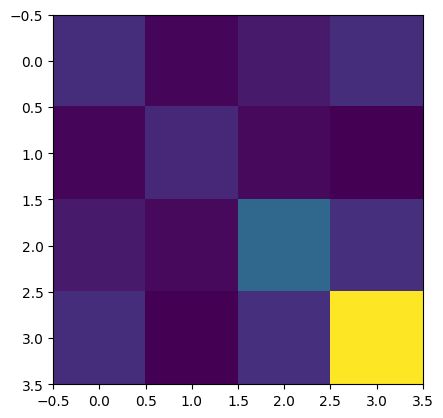

In [2]:
plt.imshow(cov_matrix, interpolation="nearest")
plt.show()

In [3]:
from qiskit_finance.applications.optimization import PortfolioOptimization

In [4]:
mu = mean_returns.values
sigma = cov_matrix.values
portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=risk_tolerance, budget=budget
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 9.047799377773024e-05*x_0^2 + 2.468211138268685e-0..., 4 variables, 1 constraints, 'Portfolio optimization'>

In [5]:
def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

In [6]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [1. 1. 1. 1.], value -0.0067

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
 [1 1 1 1]	-0.0067		1.0000
